# Implement prompt Caching using Langchain for building efficient LLM applications.



Author: Shalini Harkar 


# What is Prompt Caching?

Prompt caching is a way to store and then reuse the responses generated from executed prompts when working with language models like [Granite models](https://www.ibm.com/granite). If the same input (prompt) is encountered again, rather than making a new API call, the application will retrieve the previously stored response in the prompt cache.

Think of prompt caching as a kind of "memory" for your application. The system keeps results from previous queries in order to save computation time by not having to make repeated requests against the same input.

# Why is it important?


Prompt caching is significant because it avoids repeated API calls by reusing existing responses for identical repeated prompts, which results in faster response time, consistent output, and lower usage of the API, which is helpful for staying within rate limits. This also helps to scale the flow, and create resilience during outages. Prompt caching is a critical value adding feature for any cost effective, efficient, and user friendly AI application.

# Prerequisites



1. You need aYou need an [IBM Cloud account](https://cloud.ibm.com/registration?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-implement-xgboost-in-python&cm_sp=ibmdev-_-developer-_-trial) to create a [watsonx.ai](https://www.ibm.com/products/watsonx-ai?utm_source=ibm_developer&utm_content=in_content_link&utm_id=tutorials_awb-implement-xgboost-in-python&cm_sp=ibmdev-_-developer-_-product) project. 

2. You also need Python version 3.12.7

# Steps to follow:


### Step 1. Set up your environment

While you can choose from several tools, this tutorial walks you through how to set up an IBM account to use a Jupyter Notebook. 

1. Log in to [watsonx.ai](https://dataplatform.cloud.ibm.com/registration/stepone?context=wx&apps=all) using your IBM Cloud® account.

2. Create a [watsonx.ai project](https://www.ibm.com/docs/en/watsonx/saas?topic=projects-creating-project).

	You can get your project ID from within your project. Click the **Manage** tab. Then, copy the project ID from the **Details** section of the **General** page. You need this ID for this tutorial.

3. Create a [Jupyter Notebook](https://www.ibm.com/docs/en/watsonx/saas?topic=editor-creating-managing-notebooks).

	This step opens a Jupyter Notebook environment where you can copy the code from this tutorial.  Alternatively, you can download this notebook to your local system and upload it to your watsonx.ai project as an asset. To view more Granite tutorials, check out the [IBM Granite Community](https://github.com/ibm-granite-community). 

### Step 2. Set up a watsonx.ai Runtime instance and API key.

 

1. Create a [watsonx.ai Runtime](https://cloud.ibm.com/catalog/services/watsonxai-runtime) service instance (choose the Lite plan, which is a free instance).

2. Generate an [API Key](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-authentication.html).

3. Associate the watsonx.ai Runtime service to the project you created in [watsonx.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/assoc-services.html?context=cpdaas).

### Step 3. Installation of the packages.



We need libraries to work with langchain framework and WatsonxLLM. Let's first install the required packages. This tutorial is built using Python 3.12.7


*Note: If you are using old version of `pip`, you can use the command `pip install --upgrade pip` to upgrade it as it helps you in easy installation of latest packages, which may not compatable with old version. But if you are already using the latest version or recently upgraded you packages, then you can skip this command*.

In [ ]:
!pip install -q langchain langchain-ibm langchain_experimental langchain-text-splitters langchain_chroma transformers bs4 langchain_huggingface sentence-transformers

### Step 4. Import Required Libraries.


`os` module is used to access environment variables, such as project credentials or API keys. 

`WatsonxLLM` is a module from langchain_ibm that integrates IBM Watson LLM for generating outputs from generative AI models. 

`ChatWatsonx` Enables chat-based interactions using IBM Watsonx through LangChain. 

`SimpleDirectoryReader`is for loading and reading documents from a directory for indexing with LlamaIndex.

`GenParams` contains metadata keys for configuring Watsonx text generation parameters.

`SQLiteCache` enables setting up a local .cache.db SQLite database to avoid redundant API calls and speed up development/testing.


We need a few libraries and modules for this tutorial. Make sure to import the following ones and if they're not installed, a quick pip installation resolves the problem.

 
 

In [2]:
import os
import getpass
import requests
import random
import json
from typing import Dict, List
from langchain_ibm import WatsonxLLM
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams
from langchain_ibm import WatsonxLLM
from langchain_ibm import ChatWatsonx
from llama_index.core import SimpleDirectoryReader

### Step 5: Read the text data

In [ ]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["~/Artificial Intelligence/Generative_AI/files/FIle2.txt"],
).load_data()

document_text = documents[0].text
print(document_text[:200] + "...")



### Step 6. Set Up Credentials.

This code sets up credentials for accessing the IBM Watson Machine Learning (WML) API and ensures the project ID is correctly configured.

- A dictionary `credentials` is created with the *WML service URL* and *API key*. The API key is securely collected using `getpass.getpass` to avoid exposing sensitive information.
- the code tries to fetch the `PROJECT_ID` from environment variables using `os.environ`. If the `PROJECT_ID` is not found, the user is prompted to manually enter it via input.

In [ ]:
# Set up credentials
credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",  # Replace with the correct region if needed
    "apikey": getpass.getpass("Please enter your WML API key (hit enter): ")
}

# Set up project_id
try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

### Step 7. Initialize Large Language Model.

This code initializes the IBM Watson LLM for use in the application:

1. This code creates an instance of `WatsonxLLM` using the `ibm/granite-3-8b-instruct` model, designed for instruction-based generative AI tasks.
2. The `url`, `apikey`, and `project_id` values from the previously set up credentials are passed to authenticate and connect to the IBM Watson LLM service.
3. Configures the `max_new_tokens` parameter to limit the number of tokens generated by the model in each response (2000 tokens in this case).

To learn more about these model parameters, such as the minimum and maximum token limits, refer to the [documentation](https://ibm.github.io/watsonx-ai-python-sdk/fm_model.html#metanames.GenTextParamsMetaNames).

In [ ]:
llm = WatsonxLLM(
    model_id= "ibm/granite-3-8b-instruct", 
    url=URL,
    apikey=WATSONX_APIKEY,
    project_id=WATSONX_PROJECT_ID,
    params={
        GenParams.DECODING_METHOD: "greedy",
        GenParams.TEMPERATURE: 0,
        GenParams.MIN_NEW_TOKENS: 5,
        GenParams.MAX_NEW_TOKENS: 2000,
        GenParams.REPETITION_PENALTY:1.2,
        GenParams.STOP_SEQUENCES: ["\n\n"]
    }
)

 ### Step 8: Set up SQLite cache for faster LLM responses. 

SQLiteCache is a persistent caching tool offered by LangChain which stores responses from LLM calls in a SQLite database file.
 SQLiteCache smartly cuts down on CPU time by storing costly computations, which means it focusses on retrieving data instead of recalculating it. Rather than going through the whole process again, it simply pulls results from the disk—making it efficient, reliable, and reusable.

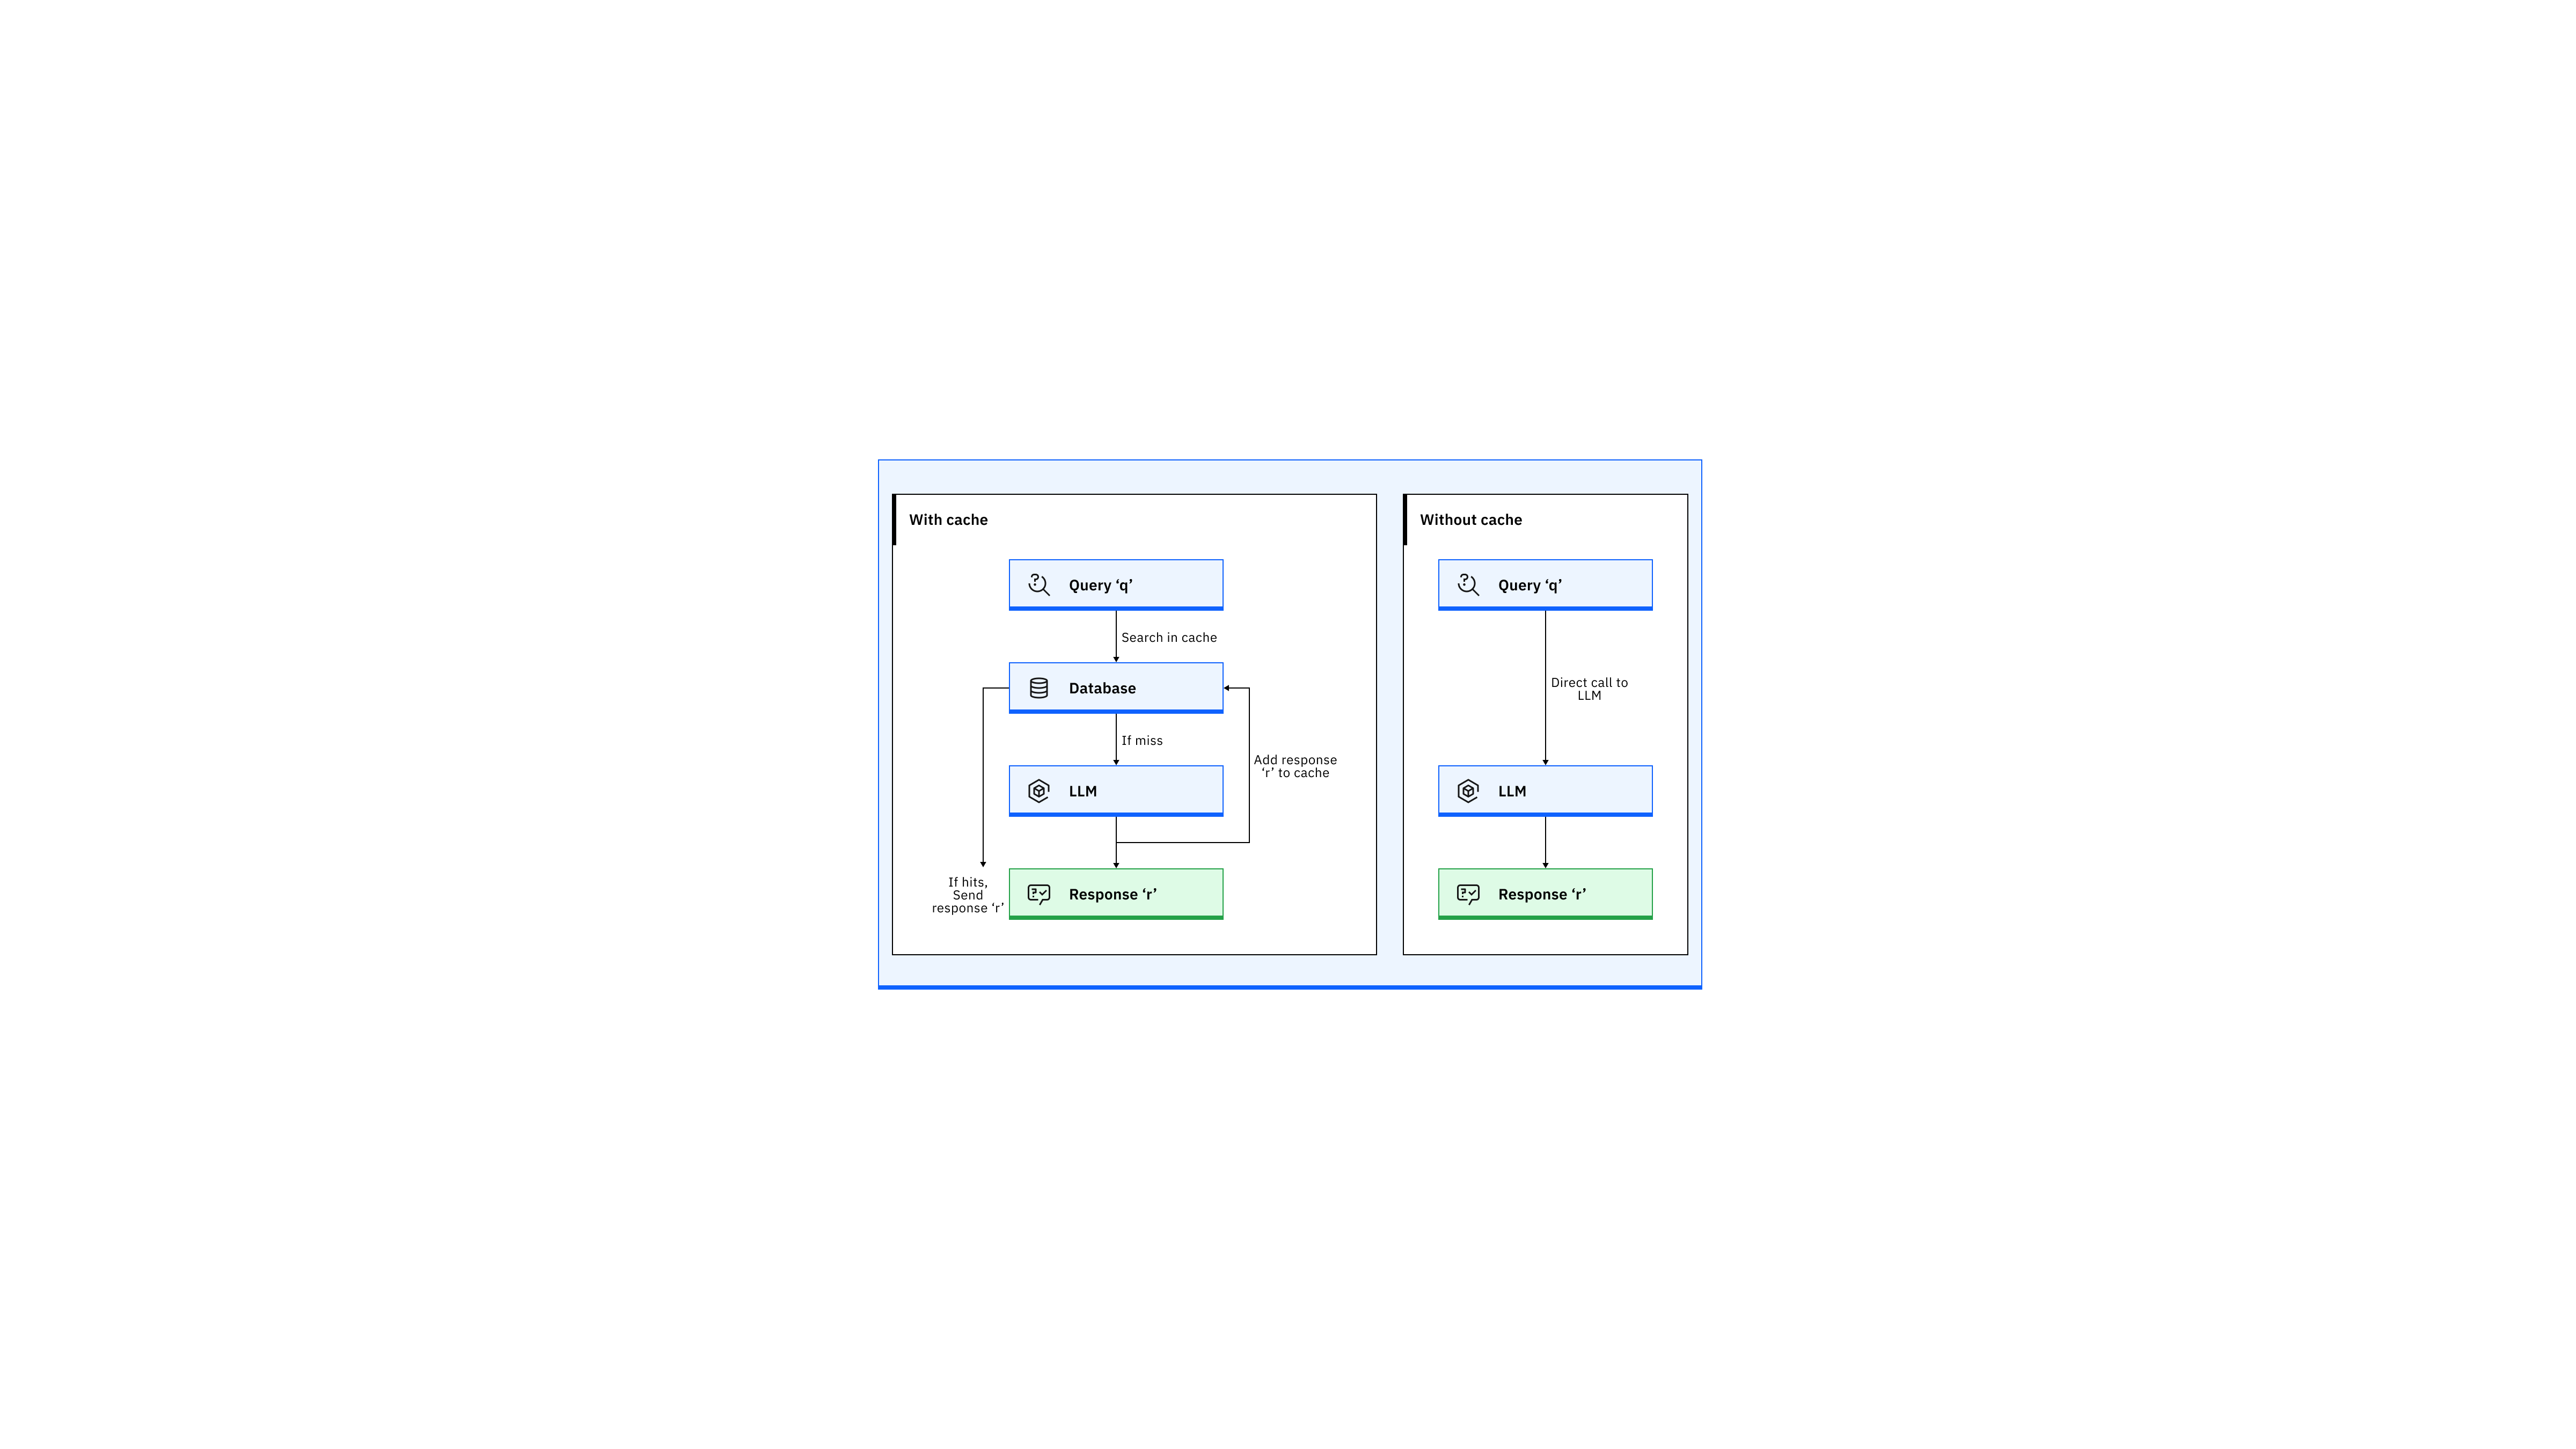

In [1]:
import os
from IPython.display import Image, display  # This Image is correct!

# Expand the path to your image
img_path = os.path.expanduser('~/Desktop/Prompt_caching workflow.png')

# Display the image
display(Image(filename=img_path))

### Figure illustrates with prompt caching, how results load instantly from disk; without it, every query wastes time on redundant computation.

In [ ]:
from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache
set_llm_cache(SQLiteCache(database_path=".langchain.db"))


In [ ]:
%%time
prompt = "System: You are a helpful assistant.\nUser: Why did Paul Graham start YC?\nAssistant:"
resp = llm.invoke(prompt)
print(resp)

In this case, CPU only worked for 22 ms, but the actual elapsed time was 1.43 seconds.

This suggests most of the time was spent waiting, likely for I/O operations (e.g., disk read/write, network access, or API call)



### Now, lets hit the model second time with the prompt and see the response time. 

In [ ]:
%%time
llm.predict(resp)

Clearly, using SQLiteCache,  the CPU is used for just 7.26 ms, but wall time was 6.15 seconds.

This clearly points to blocking external dependencies (like waiting for a response from a server).

# Conclusion

Prompt caching accelerates and reduces the cost of API requests to large language models, such as GPT-4o. Prompts cache content such as input tokens, output tokens, embeddings, and messages from user, a system prompt, or the output of a function, which now uses a cached content as opposed to network requests for a new revision. This provides lower pricing, improved response latency, and improved key performance indicators (KPIs).

Prompt caching can be beneficial for chatbots, RAG systems, fine tuning and code assistants. A robust caching strategy that includes functions such as cache read, cache write, system message, cache control, and proper time to live (TTL) will improve cache hit rates and lower cache miss rates.

Consistent use of the same prompt tokens, prompt prefix, and uses system instructions, helps with consistent prompt performance in multi-turn conversations and subsequent requests. Regardless of using Python, an SDK, or working with OpenAI or another provider, understanding how prompt caching works will better enable you to implement prompt caching for use in many use cases.